In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
#import our CSV file
df = pd.read_csv('2019.csv')

#drop unneccessary columns
df.drop(['Rk', '2PM', '2PP', 'FantPt', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'PPR', 'Fmb', 'GS'], axis=1, inplace=True)

#fix name formatting
df['Player'] = df['Player'].apply(lambda x: x.split('*')[0]).apply(lambda x: x.split('\\')[0])

#rename columns
df.rename({
    'TD': 'PassingTD',
    'TD.1': 'RushingTD',
    'TD.2': 'ReceivingTD',
    'TD.3': 'TotalTD',
    'Yds': 'PassingYDs',
    'Yds.1': 'RushingYDs',
    'Yds.2': 'ReceivingYDs',
    'Att': 'PassingAtt',
    'Att.1': 'RushingAtt'
}, axis=1, inplace=True)

#seperate dataframes based off position
rb_df = df[df['FantPos'] == 'RB']
qb_df = df[df['FantPos'] == 'QB']
wr_df = df[df['FantPos'] == 'WR']
te_df = df[df['FantPos'] == 'TE']

In [4]:
rushing_columns = ['RushingAtt', 'RushingYDs', 'Y/A', 'RushingTD',]
receiving_columns = ['Tgt', 'Rec', 'ReceivingYDs', 'Y/R', 'ReceivingTD']
passing_columns = ['PassingAtt', 'PassingYDs', 'PassingTD', 'Int']

def transform_columns(df, new_column_list):
    df = df[['Player','Tm', 'Age', 'G'] + new_column_list + ['FL']]
    return df

In [5]:
rb_df = transform_columns(rb_df, rushing_columns+receiving_columns)
wr_df = transform_columns(wr_df, rushing_columns+receiving_columns)
te_df = transform_columns(te_df, receiving_columns)
qb_df = transform_columns(qb_df, passing_columns)

rb_df.head()

,Player,Tm,Age,G,RushingAtt,RushingYDs,Y/A,RushingTD,Tgt,Rec,ReceivingYDs,Y/R,ReceivingTD,FL
0,Christian McCaffrey,CAR,23,16,287,1387,4.83,15,142,116,1005,8.66,4,0
2,Derrick Henry,TEN,25,15,303,1540,5.08,16,24,18,206,11.44,2,3
3,Aaron Jones,GNB,25,16,236,1084,4.59,16,68,49,474,9.67,3,2
4,Ezekiel Elliott,DAL,24,16,301,1357,4.51,12,71,54,420,7.78,2,2
5,Dalvin Cook,MIN,24,14,250,1135,4.54,13,63,53,519,9.79,0,2


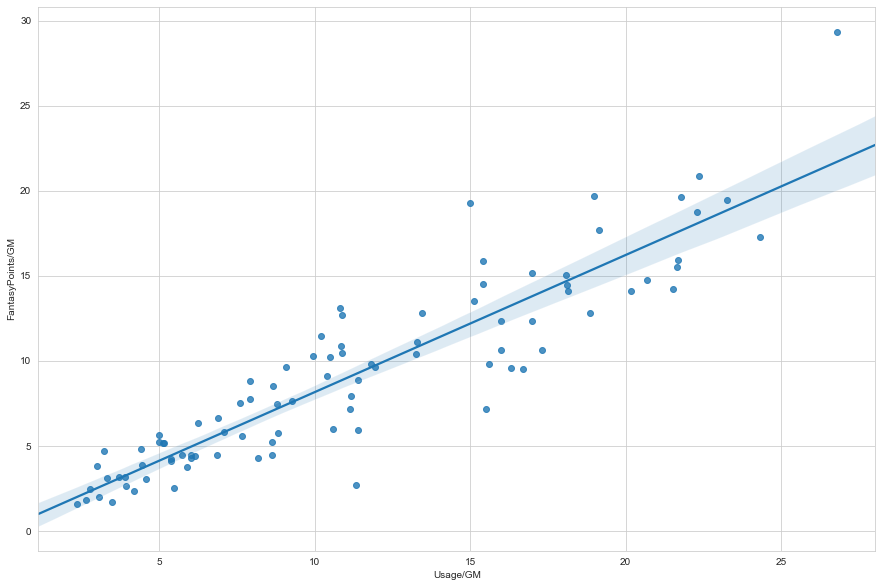

In [12]:
#How did Targets + Rushing TDs correlate to fantasy points per game for Running Backs in 2019?

#Create new column to calculate fantasy points scored (Note: this is full PPR)
rb_df['FantasyPoints'] = (rb_df['RushingYDs']*0.1 + rb_df['RushingTD']*6 + rb_df['Rec'] 
                          + rb_df['ReceivingYDs']*0.1 + rb_df ['ReceivingTD']*6 - rb_df['FL']*2)

#Create new column for Fantasy points per game.
rb_df['FantasyPoints/GM'] = rb_df['FantasyPoints']/rb_df['G']
rb_df['FantasyPoints/GM'] = rb_df['FantasyPoints/GM'].apply(lambda x: round(x, 2))

#Create new column for usage per game. Usage is defined as # of targets + carries
rb_df['Usage/GM'] = (rb_df['RushingAtt'] + rb_df['Tgt'])/rb_df['G']
#round each row value to two decimal places
rb_df['Usage/GM'] = rb_df['Usage/GM'].apply(lambda x: round(x, 2))

#just for syling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

#basic regression scatter plot with trendline
plot = sns.regplot(
    x=rb_df['Usage/GM'], 
    y=rb_df['FantasyPoints/GM'],
    scatter=True,)

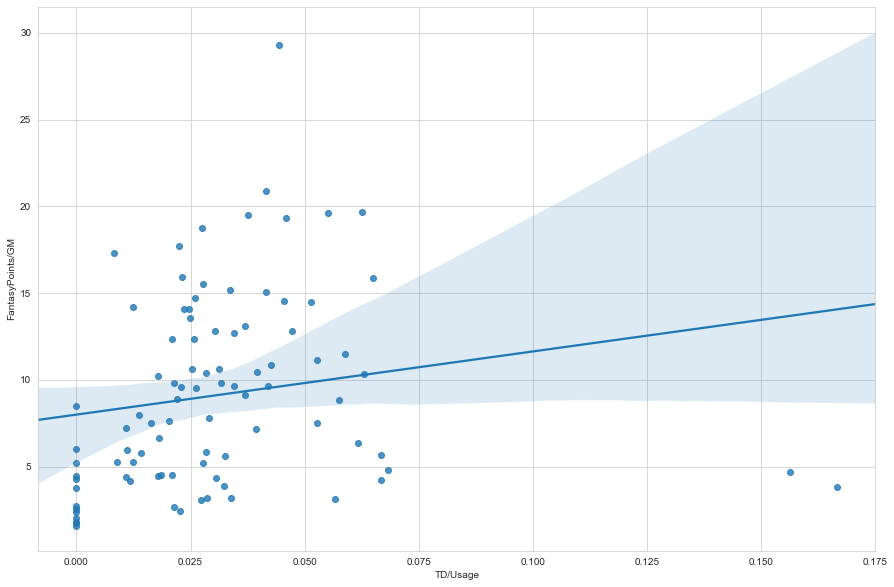

In [13]:
#How does efficiency correlate to fantasy football performance?
rb_df['TD/Usage'] = (rb_df['RushingTD']+ rb_df['ReceivingTD'])/(rb_df['RushingAtt'] + rb_df['Tgt'])

#Make sure there is an adequete sample size

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

rb_df = rb_df[rb_df['RushingAtt'] > 20]

plot = sns.regplot(
    x=rb_df['TD/Usage'],
    y=rb_df['FantasyPoints/GM'],
    scatter=True)

KeyError: 'RushingAtt/GM'

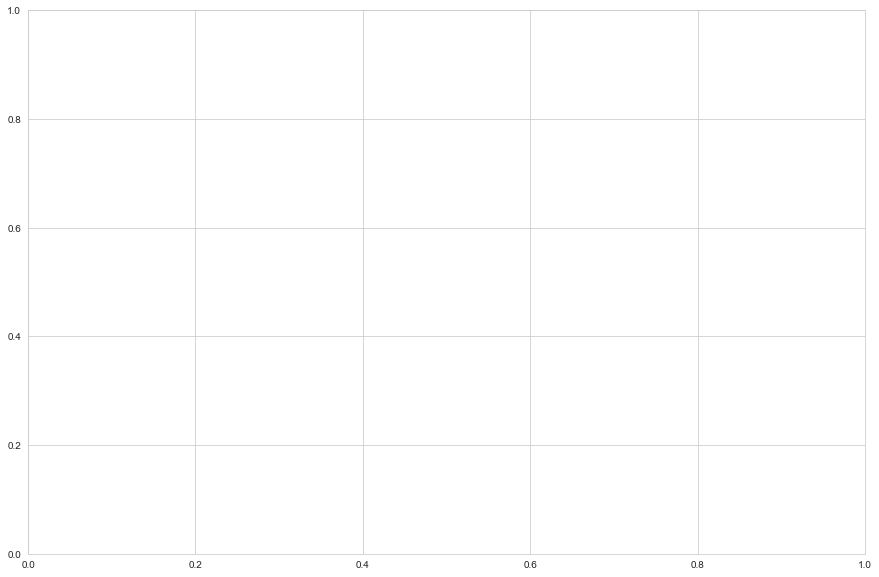

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

plot = sns.regplot(
    x=rb_df[rb_df['RushingAtt'] > 20]['RushingAtt/GM'],
    y=rb_df[rb_df['RushingAtt'] > 20]['FantasyPoints/GM'],
    scatter=True)

In [15]:
rb_df.head()

,Player,Tm,Age,G,RushingAtt,RushingYDs,Y/A,RushingTD,Tgt,Rec,ReceivingYDs,Y/R,ReceivingTD,FL,FantasyPoints,FantasyPoints/GM,Usage/GM,TD/Usage
0,Christian McCaffrey,CAR,23,16,287,1387,4.83,15,142,116,1005,8.66,4,0,469.2,29.33,26.81,0.044289
2,Derrick Henry,TEN,25,15,303,1540,5.08,16,24,18,206,11.44,2,3,294.6,19.64,21.80,0.055046
3,Aaron Jones,GNB,25,16,236,1084,4.59,16,68,49,474,9.67,3,2,314.8,19.68,19.00,0.062500
4,Ezekiel Elliott,DAL,24,16,301,1357,4.51,12,71,54,420,7.78,2,2,311.7,19.48,23.25,0.037634
5,Dalvin Cook,MIN,24,14,250,1135,4.54,13,63,53,519,9.79,0,2,292.4,20.89,22.36,0.041534
